# Project 1

## 1. Introduction

### Challenge

The objective of this project is to build a machine learning model that can predict four key repair outcomes of CRISPR-Cas9 editing experiments based on provided DNA sequences. Specifically, the aim is to accurately predict:
- **Fraction_Insertions**: The fraction of indel reads that resulted in insertions.
- **Avg_Deletion_Length**: The average length of deletions observed.
- **Indel_Diversity**: A measure of the variability in indel types and lengths.
- **Fraction_Frameshifts**: The fraction of repair outcomes that lead to a frameshift mutation.

The primary goal of this project is predictive accuracy—to develop a machine learning model capable of reliably predicting the specified CRISPR-Cas9 repair outcomes based on the input features. This makes the problem prediction-focused, rather than inferential, as the emphasis is on optimizing performance metrics (e.g., R², Mean Squared Error) rather than understanding the specific causal relationships between the predictors and outcomes.

Let's visualise which models looks the best to use according to our objective:

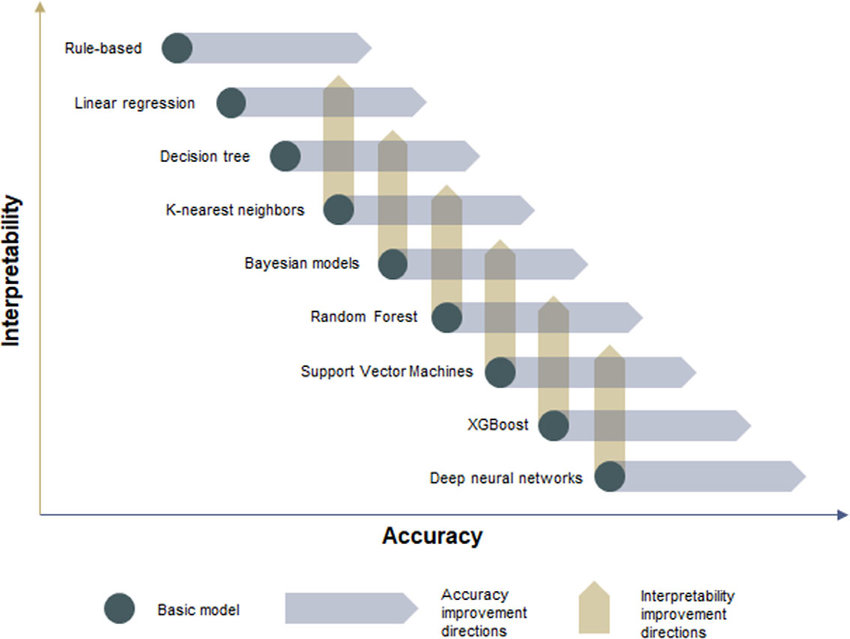

**Fig. 6.**. Interpretability vs accuracy trade-off: main models and their improvement directions [@misc] .

By interpretating the image we can conclude that the best model for this challenge would, in theory, be the XGXboost. 

The data used to make this model was obtained by Leenay et. al. (2019) and in the same article a machine learning model (SPROUT) was made in order to predict the the length, probability and sequence of nucleotide insertions and deletions, and, consequently, facilitate design of SpCas9 guide RNAs in therapeutically important primary human cells. 

Therefore, to construct our model we will take into account some important considerations they have taken into account in the SPROUP model. For instance, we know that the model takes as input the 20 nucleotides of the spacer sequence plus the PAM. Therefore, we will try this using this two features as input/predictor variables. Moreover, the model was trained and evaluated using five-fold cross validation, we will keep this in mind for later on our project. Additionally, the researchers concluded that SPROUT was able to accurately predict the fraction of indel mutant reads with an insertion (R2 = 0.59) and the fraction of total reads with an insertion (R2 = 0.40). We can, later, analyse our results given this information obtained. 

## 2. Library Importation

To efficiently analyze and model the CRISPR-Cas9 DNA sequence data, we imported several key libraries:

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Preprocessing and feature engineering
from sklearn.preprocessing import StandardScaler       # Standardizes features by removing the mean and scaling to unit variance
from sklearn.preprocessing import OneHotEncoder        # Encodes categorical features as one-hot numeric arrays
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial and interaction features

# Model building and evaluation
from sklearn.svm import SVR                            # Support Vector Regressor for building SVM models
from sklearn.multioutput import MultiOutputRegressor   # Handles multi-target regression by training one model per target
from sklearn.model_selection import RandomizedSearchCV # For hyperparameter tuning using randomized search

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer # Converts DNA sequences into a matrix of token counts

import matplotlib.pyplot as plt
import seaborn as sns


#from sklearn.metrics import mean_squared_error
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import scale


## 3. Data Loading and Preprocessing

To begin our analysis, we first load the training and testing datasets, provided in CSV format, which contain DNA sequence data and associated repair outcomes.

In [2]:
# Load the training and testing data from CSV files
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Set 'Id' column as the index for easy reference to each record
train_data = train_data.set_index("Id")
test_data = test_data.set_index("Id")

The training data (**train_data**) contains labeled examples that will be used to train the model, while the test data (**test_data**) contains DNA sequences for which we want to predict the repair outcomes. Setting the "Id" column as the index helps us keep track of individual sequences throughout the preprocessing and prediction stages.

### 3.1 Checking each dataset

Once the datasets are loaded, I'll check their structure and basic statistics to ensure they are properly formatted and contain the expected data.

* **train_data**

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065 entries, 0 to 1064
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GuideSeq              1065 non-null   object 
 1   Fraction_Insertions   1065 non-null   float64
 2   Avg_Deletion_Length   1065 non-null   float64
 3   Indel_Diversity       1065 non-null   float64
 4   Fraction_Frameshifts  1065 non-null   float64
dtypes: float64(4), object(1)
memory usage: 82.2+ KB


We are able to check that there are 5 columns:
- **GuideSeq**: The DNA sequence used in the CRISPR-Cas9 knockout experiments. This sequence includes the 20-nucleotide guide RNA sequence plus the 3-nucleotide Protospacer Adjacent Motif (PAM) sequence.
- **Fraction_Insertions**: The fraction of indel reads that resulted in insertions.
- **Avg_Deletion_Length**: The average length of deletions observed.
- **Indel_Diversity**: A measure of the variability in indel types and lengths.
- **Fraction_Frameshifts**: The fraction of repair outcomes that lead to a frameshift mutation.

Moreover, we can conclude that there are 1065 entries and each column has a full set of non-null values, meaning there are no missing entries in this dataset

Next, the describe() method provides basic statistics like mean, standard deviation, min, max, and percentiles for each of the numerical columns, giving insight into the distribution of the repair outcomes

In [ ]:
train_data.head()

Given that the response variables are continuous, this project is framed as a regression problem where the objective is to predict numerical values for each outcome variable.

In [6]:
train_data.describe()

,Fraction_Insertions,Avg_Deletion_Length,Indel_Diversity,Fraction_Frameshifts
count,1065.000000,1065.000000,1065.000000,1065.000000
mean,0.209327,7.370845,3.800805,0.698444
std,0.153476,3.003263,0.709694,0.123423
min,0.001168,2.346479,1.151684,0.001676
25%,0.088558,5.421346,3.357909,0.641393
50%,0.164405,6.977368,3.857114,0.714457
75%,0.292504,8.773226,4.302568,0.780449
max,0.831198,46.027027,5.548348,0.954305


* **test_data**

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   GuideSeq  304 non-null    object
dtypes: object(1)
memory usage: 4.8+ KB


The test_data consists of 304 entries and only contains one column:

* **GuideSeq**: The DNA sequence used in the CRISPR-Cas9 experiments.

We can confirm that the test_data does not contain any missing values.

### 3.2 Preparing Test Data for Predictions

To facilitate the later prediction of the four target variables, we add new columns in the test data (`test_data`) for each repair outcome (`Fraction_Insertions`, `Avg_Deletion_Length`, `Indel_Diversity`, and `Fraction_Frameshifts`). Initially, these columns are filled with `NaN` values, indicating that these are the variables we intend to predict.


In [10]:
# Add new columns with NaN values
target_columns = ['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']

for col in target_columns:
    test_data[col] = np.nan

# Display the modified test_data
test_data.head()

,GuideSeq,Fraction_Insertions,Avg_Deletion_Length,Indel_Diversity,Fraction_Frameshifts
Id,,,,,
0,TGTGCAATATCTGGTACTAAGGG,NaN,NaN,NaN,NaN
1,TGTCTGGCCAGCAGAATACAGGG,NaN,NaN,NaN,NaN
2,ACTGAGAGTGGATCCGAAAGTGG,NaN,NaN,NaN,NaN
3,GTTCTGCACCAGCACATTCACGG,NaN,NaN,NaN,NaN
4,ACTGGATGGACAAGACTGGTGGG,NaN,NaN,NaN,NaN


### 3.3 Defining X (Features/Input Variables) and y (Targets/Output Variables)

To prepare the data for training, I specified the target variables (y) and feature variables (X). The target variables are the four repair outcomes to be predicted, while the feature variables are the DNA sequence data that will serve as the predictors in the model.

In [11]:
# Specify target variables (y) - the outcomes we aim to predict
y_train = train_data[['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']].values
y_test = test_data[['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']].values

# Specify feature variables (X) - the data used for prediction, excluding the GuideSeq and target columns
X_train = train_data.drop(['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts'], axis=1)
X_test = test_data.drop(['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts'], axis=1)

### 3.4  Preprocessing the DNA Sequences

* Separating the DNA sequence

Let's separate the 23 nucleotide sequences into two parts—one containing the first 20 nucleotides and the other containing the last 3 nucleotides. The last 3 nucleotides are The protospacer adjacent motif (or PAM for short) is a short DNA sequence (usually 2-6 base pairs in length) that follows the DNA region targeted for cleavage by the CRISPR system, such as CRISPR-Cas9.

In [18]:
# Extract the GuideSeq column as a list of sequences
guide_seqs_train = X_train['GuideSeq']
guide_seqs_test = X_test['GuideSeq']

# Split each sequence into two parts: first 20 nucleotides and last 3 nucleotides
X_train_first_20 = [seq[:20] for seq in guide_seqs_train]
X_train_PAM = [seq[20:] for seq in guide_seqs_train]

X_test_first_20 = [seq[:20] for seq in guide_seqs_test]
X_test_PAM = [seq[20:] for seq in guide_seqs_test]

#### 3.3.1 One-Hot Encoding the DNA Sequences

We apply One-Hot Encoding to the DNA sequences, converting each nucleotide into a binary vector representation. In general, dummy variables are introduced to encode categorical features. In machine learning, this is more often called **one-hot encoding**

In [23]:
from sklearn.preprocessing import OneHotEncoder

# Initialize encoders
encoder_20 = OneHotEncoder(categories=[['A', 'T', 'C', 'G']]*20)
encoder_PAM = OneHotEncoder(categories=[['A', 'T', 'C', 'G']]*3)

# Transform the first 20 nucleotides
X_train_20_encoded = encoder_20.fit_transform([list(seq) for seq in X_train_first_20])
X_test_20_encoded = encoder_20.transform([list(seq) for seq in X_test_first_20])

# Transform the PAM sequence
X_train_PAM_encoded = encoder_PAM.fit_transform([list(seq) for seq in X_train_PAM])
X_test_PAM_encoded = encoder_PAM.transform([list(seq) for seq in X_test_PAM])

Next, we concatenate the encoded first 20 nucleotides and PAM sequence features for each dataset:

In [24]:
from scipy.sparse import hstack

# Concatenate the encoded features
X_train_combined = hstack([X_train_20_encoded, X_train_PAM_encoded])
X_test_combined = hstack([X_test_20_encoded, X_test_PAM_encoded])

#### 3.3.2 Applying TF-IDF 

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to convert sequences into k-mers
def generate_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

# Apply the k-mer function to all sequences in your training and test data
X_train_kmers = [" ".join(generate_kmers(seq, k=3)) for seq in X_train_array]
X_test_kmers = [" ".join(generate_kmers(seq, k=3)) for seq in X_test_array]

# Set up the TF-IDF Vectorizer for the k-mers
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training k-mers and transform both train and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_kmers)
X_test_tfidf = tfidf_vectorizer.transform(X_test_kmers)

Doing it with this approach, the result was slighter worse compared to using the one hot enconding approach. 

## 4. Data Exploration

### 4.1 Visualizing the Distribution of the Output Variables

 Visualizing the distribution helps to understand the underlying structure of the data and identify any patterns, skewness, outliers, or other characteristics that could influence the performance of my model.

* Histograms

Histograms show how the values of a variable are distributed across different bins. This is useful for understanding the frequency of different ranges of values.

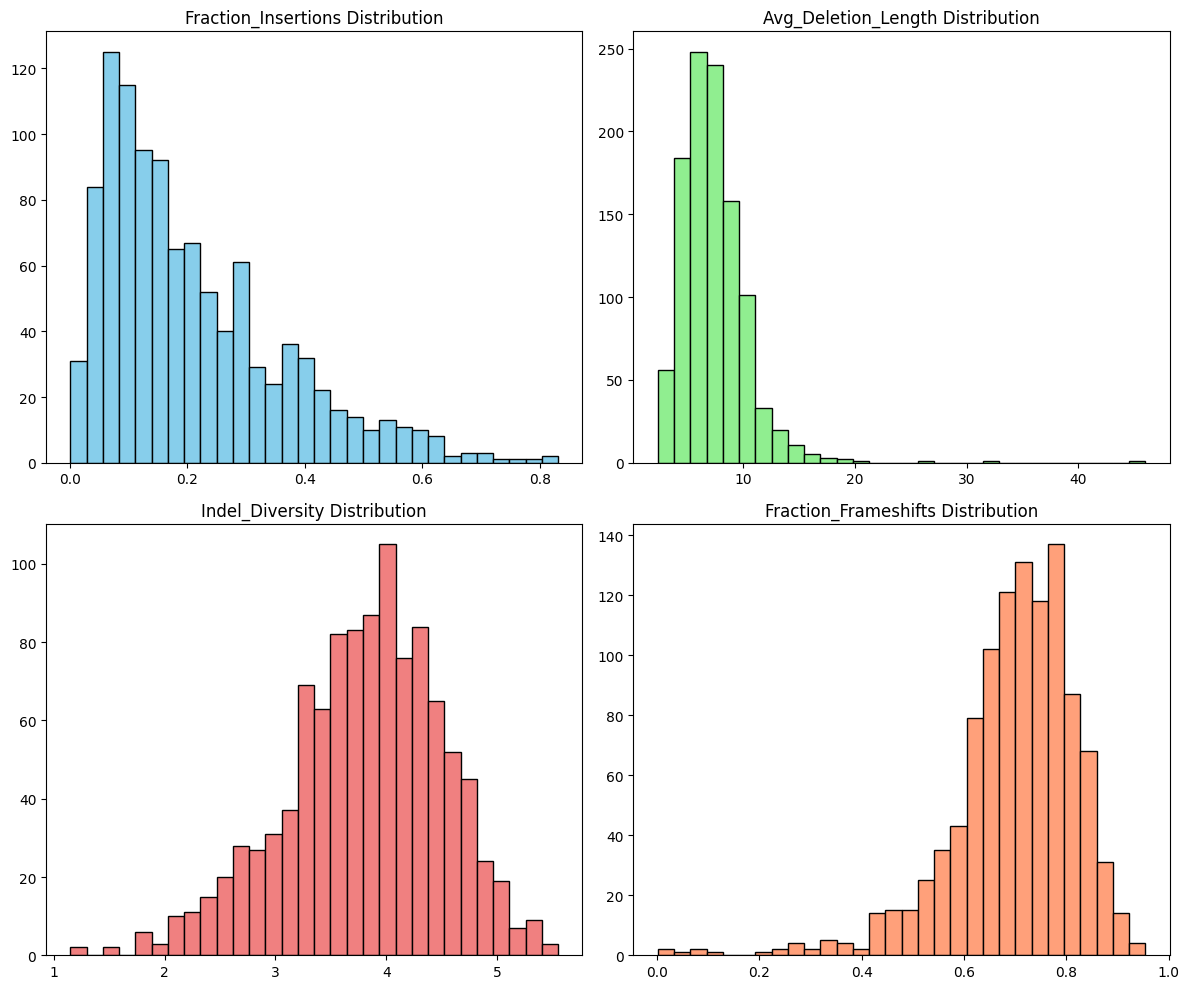

In [106]:
# Set up a figure with multiple subplots for each target variable
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot each target variable in a different subplot
axs[0, 0].hist(y_train[:, 0], bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Fraction_Insertions Distribution')

axs[0, 1].hist(y_train[:, 1], bins=30, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Avg_Deletion_Length Distribution')

axs[1, 0].hist(y_train[:, 2], bins=30, color='lightcoral', edgecolor='black')
axs[1, 0].set_title('Indel_Diversity Distribution')

axs[1, 1].hist(y_train[:, 3], bins=30, color='lightsalmon', edgecolor='black')
axs[1, 1].set_title('Fraction_Frameshifts Distribution')

# Adjust layout to make sure titles and axes fit well
plt.tight_layout()
plt.show()

* Boxplots

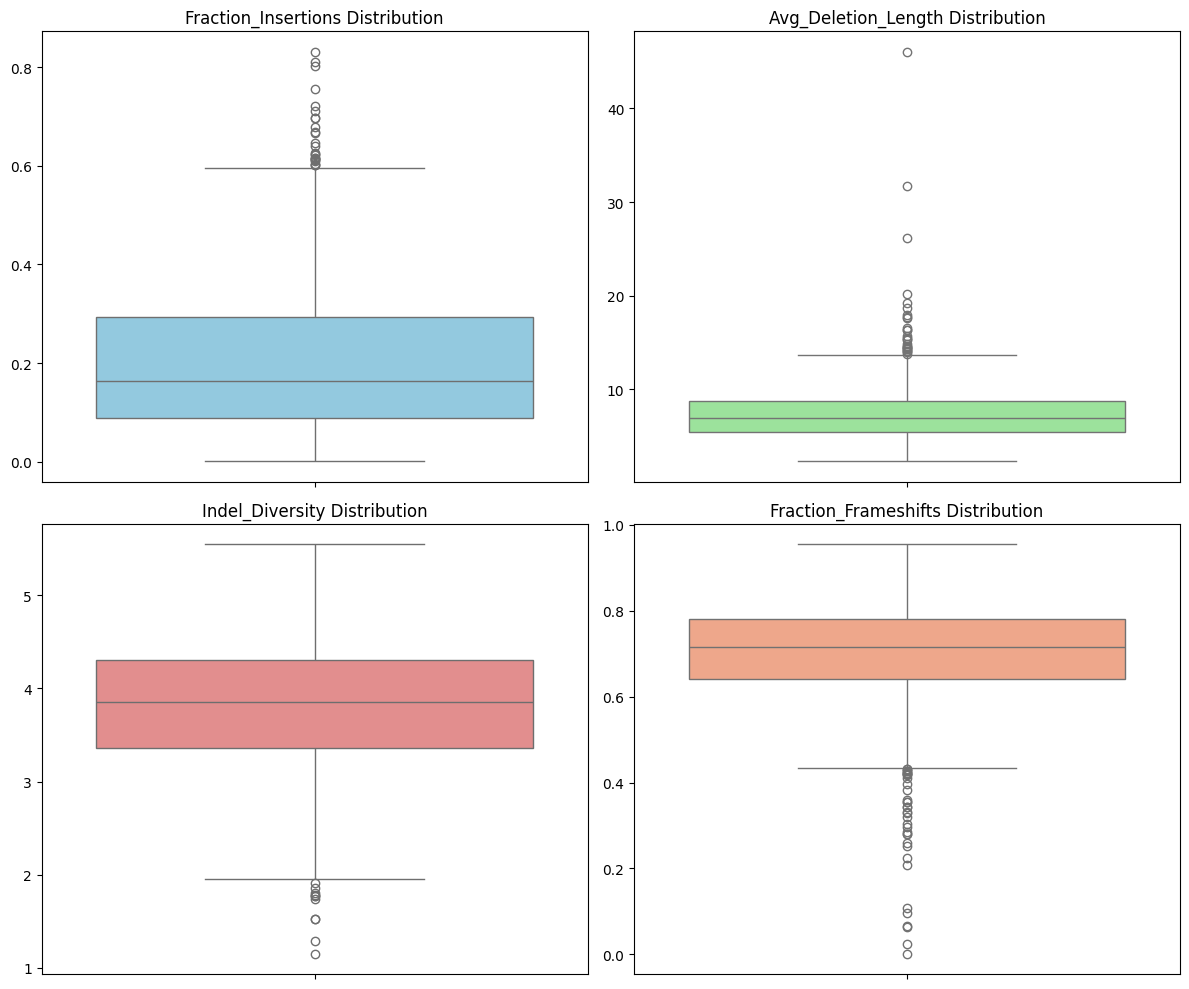

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(data=y_train[:, 0], ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Fraction_Insertions Distribution')

sns.boxplot(data=y_train[:, 1], ax=axs[0, 1], color='lightgreen')
axs[0, 1].set_title('Avg_Deletion_Length Distribution')

sns.boxplot(data=y_train[:, 2], ax=axs[1, 0], color='lightcoral')
axs[1, 0].set_title('Indel_Diversity Distribution')

sns.boxplot(data=y_train[:, 3], ax=axs[1, 1], color='lightsalmon')
axs[1, 1].set_title('Fraction_Frameshifts Distribution')

plt.tight_layout()
plt.show()


We have observed that there are outliers in all off the output variables. We can see how the models perfoms depending on how we deal with them:

* Scaling the data with Robust Scalers: Since outliers can distort standard scaling, using a Robust Scaler instead of a standard scaler, as it’s designed to reduce the influence of outliers. A robust scaler scales the data by subtracting the median and dividing by the interquartile range, which can help reduce the impact of extreme values on the model.

* Reduce the Influence of Outliers Using SVM Parameters: The C parameter in SVMs controls the trade-off between achieving a smooth decision boundary and classifying all training points correctly. A smaller C value allows the model to ignore some outliers by creating a larger margin, which can make the model more robust.

* Transform the Target Variables: Applying a transformation to compress extreme values can be particularly helpful in regression tasks. Since you’re using an arcsinh transformation on your input data, you could also apply it to your target variables.

* Experiment with Robust Kernel Functions: Some SVM kernel choices can be less influenced by outliers. For instance, the RBF (Radial Basis Function) kernel is generally more robust than the linear kernel because it uses Gaussian influence, which tends to de-emphasize the influence of far-away points.

## 5. Feature Transformation, Scaling, and Model Setup

After the data has been loaded and cleaned, we perform several preprocessing steps to prepare the features for model training. These steps help ensure that the data is in the optimal form for the SVM model and enhance model performance.

#### 4.1 Applying Arcsinh Transformation

To address potential issues with the distribution of feature values, we apply the arcsinh transformation. This transformation normalizes the features, which is beneficial for training a machine learning model like SVM.

In [ ]:
#X_train_transformed = np.arcsinh(X_train_tfidf)
#X_test_transformed = np.arcsinh(X_test_tfidf)

#### 4.2 Polynomial Feature Expansion

We apply polynomial feature expansion to increase the model’s ability to capture higher-order relationships between the features. This step is crucial for handling complex patterns that may not be captured by simple linear relationships.

In [111]:
# Polynomial feature expansion (if applicable)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_tfidf)
X_test_poly = poly.transform(X_test_tfidf)

#### 4.3 Feature Scaling

To ensure that all features have the same scale, we standardize the features using StandardScaler. This step is essential for models like SVM, which are sensitive to feature scaling.

In [114]:
# Standardize the features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

#### 4.4 SVM Model Setup and Hyperparameter Tuning

We initialize the SVM Regressor wrapped in MultiOutputRegressor and perform hyperparameter tuning using RandomizedSearchCV to optimize the model parameters.

In [115]:
# Initialize an SVM Regressor wrapped in MultiOutputRegressor
svm = SVR()
multi_target_svm = MultiOutputRegressor(svm)

# Define SVM model with parameter grid
param_grid = {
    'estimator__kernel': ['linear', 'rbf', 'poly'],       # Kernel type
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],        # Regularization parameter
    'estimator__epsilon': [0.01, 0.1, 0.2, 0.5],          # Epsilon
    'estimator__gamma': ['scale', 'auto', 0.1, 1],         # Kernel coefficient for 'rbf' and 'poly'
    'estimator__degree': [2, 3, 4, 5],                     # Degree for 'poly' kernel
    'estimator__shrinking': [True, False],                  # Shrinking heuristics
    'estimator__tol': [1e-3, 1e-4]                          # Tolerance for stopping criteria
}

# Set up GridSearchCV with MultiOutputRegressor
clf = RandomizedSearchCV(multi_target_svm, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1)
clf.fit(X_train_scaled, y_train)                                               

RandomizedSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=SVR()),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__C': [0.01, 0.1, 1, 10, 100,
                                                         1000],
                                        'estimator__degree': [2, 3, 4, 5],
                                        'estimator__epsilon': [0.01, 0.1, 0.2,
                                                               0.5],
                                        'estimator__gamma': ['scale', 'auto',
                                                             0.1, 1],
                                        'estimator__kernel': ['linear', 'rbf',
                                                              'poly'],
                                        'estimator__shrinking': [True, False],
                                        'estimator__tol': [0.001, 0.0001]})

We can split the data into training, validation and test data. Instead of using the validation dataset it is also possible to use k-fold cross-validation or stratified cross validation:

The validation set approach is a very simple way. It involves randomly dividing the available set of observations into two parts, a training set and a validation set or hold-out set.  The validationmodel is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate—typically assessed using MSE in the case of a quantitative response—provides an estimate of the test error rate.

Training Dataset: The sample of data used to fit the model.
Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
Test Dataset: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

k-fold cross-validation is impossible to use in our data because we don't have access to the test data. In the meantime, stratified cross-validation is possible to use as we can use training data and stratify into validation data.

![image.png](attachment:image.png)


Teacher’s Procedure:
Divide the sample into 
𝐾
K-folds:

Standard 
𝐾
K-fold cross-validation setup.
Feature Selection (before fitting the model):

For each fold 
𝑘
k, perform feature selection without using the data in fold 
𝑘
k (e.g., find features with high correlation to the labels using only the training data of the remaining 
𝐾
−
1
K−1 folds).
This ensures no "data leakage" from the validation fold into the feature selection process.
Nested Cross-Validation for Hyperparameter Tuning:

Inside the outer 
𝐾
K-fold loop, perform an inner cross-validation loop on the 
𝐾
−
1
K−1 training folds to fine-tune hyperparameters. This nested approach helps prevent overfitting during hyperparameter optimization.
Use the fitted model to predict the validation fold:

Once the feature selection and hyperparameter tuning are done, train the model on the training folds (with selected features) and predict on the validation fold.


#### 4.4 Define the Gradient Boosting Model

In [38]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

# Initialize an XGBoost model wrapped in MultiOutputRegressor
gb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
multi_target_gb = MultiOutputRegressor(gb_model)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 5, 7],  # Regularization through depth
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__subsample': [0.8, 0.9, 1.0],  # Helps control overfitting
    'estimator__min_child_weight': [1, 3, 5],  # Regularization similar to min_samples_split and min_samples_leaf
    'estimator__gamma': [0, 0.1, 0.2],  # Similar to ccp_alpha, regularization
}

# Use GridSearchCV for hyperparameter tuning
clf = GridSearchCV(multi_target_gb, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_combined, y_train)

# Get the best model from the grid search
best_gb_model = clf.best_estimator_

# Predictions on the test data
y_pred = best_gb_model.predict(X_test_combined)

# Print out the best parameters found by GridSearchCV
print("Best Parameters: ", clf.best_params_)

# Predict on test data
#y_pred_gb = clf.predict(X_test_combined)


Best Parameters:  {'estimator__gamma': 0, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 7, 'estimator__min_child_weight': 5, 'estimator__n_estimators': 300, 'estimator__subsample': 0.8}


Feature importance for model 0:


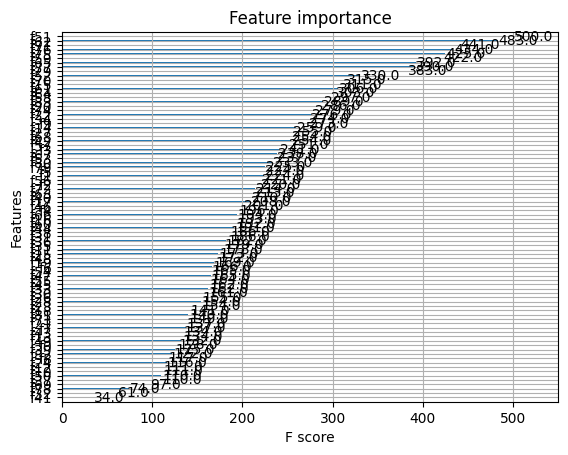

Feature importance for model 1:


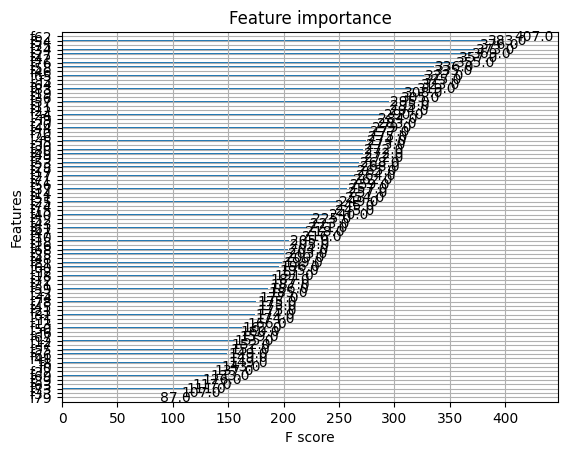

Feature importance for model 2:


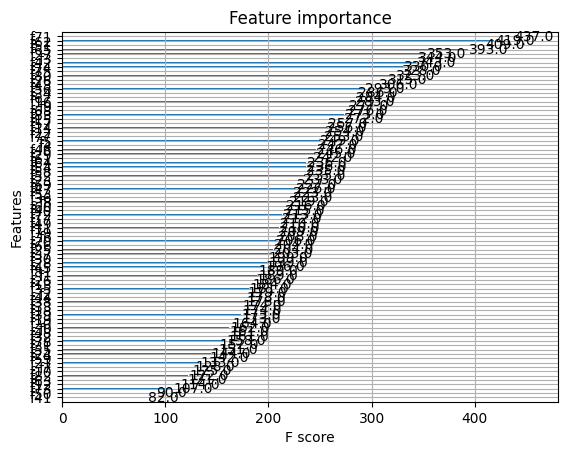

Feature importance for model 3:


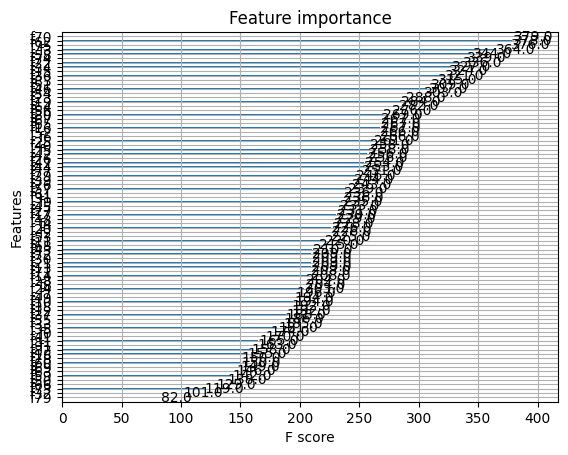

In [39]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Access the individual XGBRegressor models for each target
for i, model in enumerate(best_gb_model.estimators_):
    print(f"Feature importance for model {i}:")
    xgb.plot_importance(model)
    plt.show()


#### 4.5 Model prediction and saving results

After the model is trained, predictions are made on the test dataset, and the results are saved to a CSV file for further analysis.

In [40]:
predictions_df = pd.DataFrame(y_pred, columns=["Fraction_Insertions", 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts'])
predictions_df['Id'] = predictions_df.index

predictions_df = predictions_df[['Id', 'Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']]
predictions_df.to_csv('predictions_boost.csv', index=False)

In [ ]:
predictions_df = pd.DataFrame(y_pred, columns=["Fraction_Insertions", 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts'])
predictions_df['Id'] = predictions_df.index

predictions_df = predictions_df[['Id', 'Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']]
predictions_df.to_csv('predictions_boost.csv', index=False)

# 5. Other models

Experimentation was made using other models such as: 
* 1-Nearest neighbor regression -> poor performance on high-dimensional, complex datasets like DNA sequence data. In this setting, 1-NN struggles to capture intricate patterns and relationships necessary for accurate predictions, resulting in a high mean squared error (MSE). Unlike advanced models like gradient boosting, which generalize by learning from patterns across the dataset, 1-NN only finds the closest point, leading to high error and poor predictive accuracy in this context.
* k-NN: Even tho it makes no assumption of the data distribution.  It is a non-parametric method that makes predictions based on the similarity of data points in a given dataset. We even tried with different types of distances - euclidean and manhanttan. I found that a value of K = ? is tamong the best options when using this algorithm. k-NN is a lazy learner, which means it does not learn explicit relationships during training but instead relies on memorizing the dataset. For tasks with complex, non-linear patterns like sequence analysis, k-NN struggles to generalize effectively, leading to higher error rates.

Other considerations:
* Simple Linear Regression -> wasn't used since there is not only one independent and dependent variable
* Multiple Linear Regression -> wasn't used since there is more than one independent variable and but more than one dependent variable.
* I could use the linear model to acomodate non-linear relationship by using polynomial regression. 

Outliers: Residual plots can be used to identify outliers and are a useful graphical tool for identifying non-linearity. 
If we believe that an outlier has occurred due to an error in data collec
tion or recording, then one solution is to simply remove the observation.
However, care should be taken, since an outlier may instead indicate a
 deficiency with the model, such as a missing predictor.

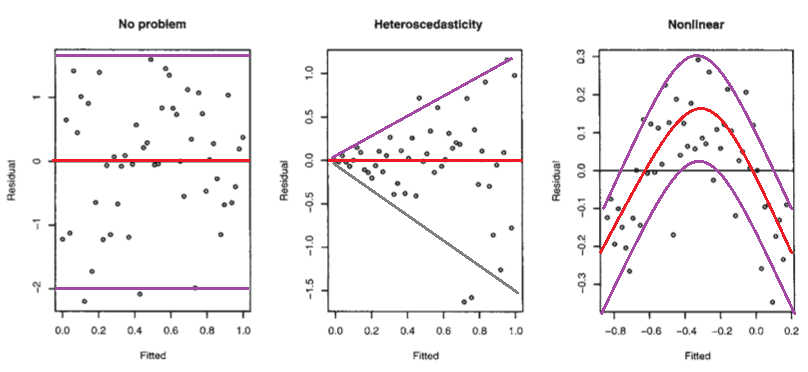


We can access multicollinearity by computing VIF and collinearity by doing a correlation matrix. 

When faced with the problem of collinearity, there are two simple solu
tions. The first is to drop one of the problematic variables from the regres
sion.  The second solution is
 to combine the collinear variables together into a single predictor.

Calculating the Mean Absolute Error (MAE):


MAE = compute_MAE(y_test, y_pred) # compute the MAE
print('Test set MAE: {}'.format(MAE))

python
Copiar código
MAE = compute_MAE(y_train, y_pred)
Here, the code calls the compute_MAE function to calculate the Mean Absolute Error (MAE) between the true values (y_train) and the predicted values (y_pred). MAE measures the average magnitude of the prediction errors, giving you an idea of how far off predictions are from the actual values without considering the direction of the errors.

The error you see should be about as big on the train set than it is on the test set. This is good news, our model is not to overly complex.

References:

- ref.bib
